In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#the main lib here is the statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

## Stock Prices Forecasting
For our practical class we will be forecasting the stock prices of some of the biggest stock markets in the world. This will be a guide on how to structure your Time Series Forecasting Project.

### 1. Problem Statement

S&P 500 is a stock market index tracking the stock performance of 500 leading companies listed on stock exchanges in the United States. The index represents the financial health and performance of the US economy. Forecasting the future prices of the index is important for fund managers, banks and investors to measure and prepare for how risky the market might be as well as guide them on when to invest more money and when to pull back.

In this project, we are going to use the historical stock prices of the S&P 500, from 1994-2018 to forecast future prices, we will test out and compare the performance of different time series models.



### 2. Loading and Exploring your data (EDA)

In [54]:
# read the data
df=pd.read_csv(r'D:\Advanced_Machine_Learning\datasets\Stock_prices.csv.csv')

In [55]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


Just like in any ML workflow, the first place to begin is checking for missingness.

In [56]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


The first thing I notice is that, our date column is not the correct data type. All time-series should be a date-time object. Second, the date column should be the index of the dataframe

In [57]:
#convert date column to datetime object
df['date']=pd.to_datetime(df['date'],errors='coerce',dayfirst=True)

In [58]:
df.set_index('date',inplace=True)

Also, the stock markets usually run during the week and close over the weekend, meaning our stock prices change from Monday to Friday, and there are no changes on Saturday and Sunday.So let's confirm that our data is accurate and reflect the stock prices during the active market days.

In [59]:
df_trading = df[df.index.dayofweek < 5]

In [60]:
df_trading.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6269 entries, 1994-01-07 to 2018-01-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6269 non-null   float64
 1   dax     6269 non-null   float64
 2   ftse    6269 non-null   float64
 3   nikkei  6269 non-null   float64
dtypes: float64(4)
memory usage: 244.9 KB


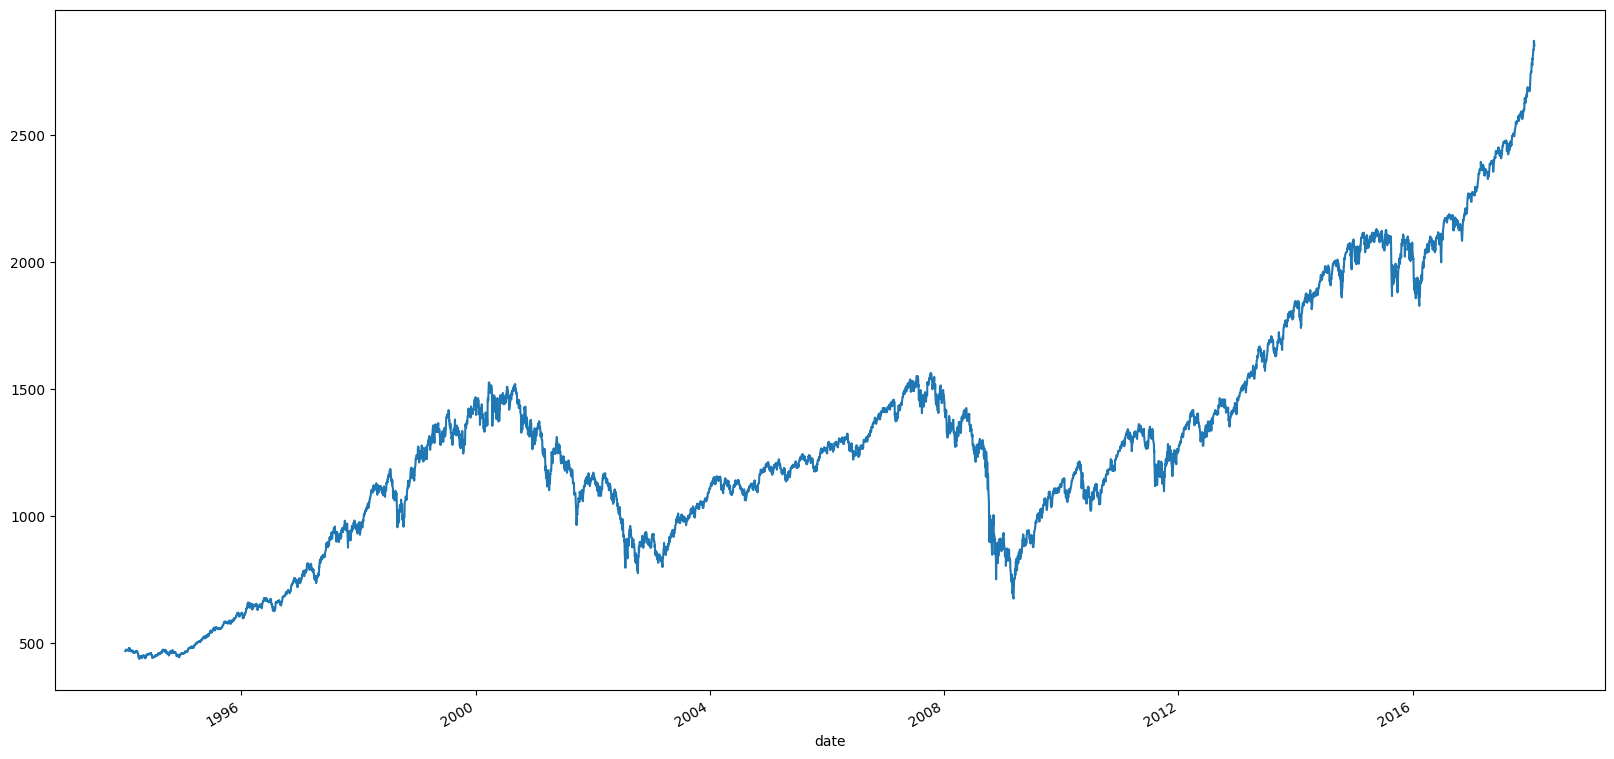

In [61]:
plt.figure(figsize=(20,10))
df_trading['spx'].plot()
plt.show()

So from the plot above, I can see some slight trend- the time series is increasing in trend. I also suspect a seasonal component. I know, it can be confusing, a great way to confirm if your data has seasonality and/or trend is to performa time-series decomposition. This just means breaking down the time-series into its trend, seasonal and residual (noise) component. We use the statsmodels library for this

Now, for time-series decomposition you have 2 options, you can perform classical decomposition or a more advanced technique. We have 2 approaches under classical, additive or multiplicative. In additive, we assume that the timeseries is a sum of the time components and multiplicative we assume its a product.

**When to choose between additive and multiplicative**
Generally, use an additive decomposition when seasonal variation is constant over time and then use multiplicative when you notice your seasonal effects become bigger with the trend. For me, I used multiplicative, because the seasonal variance is not constant.

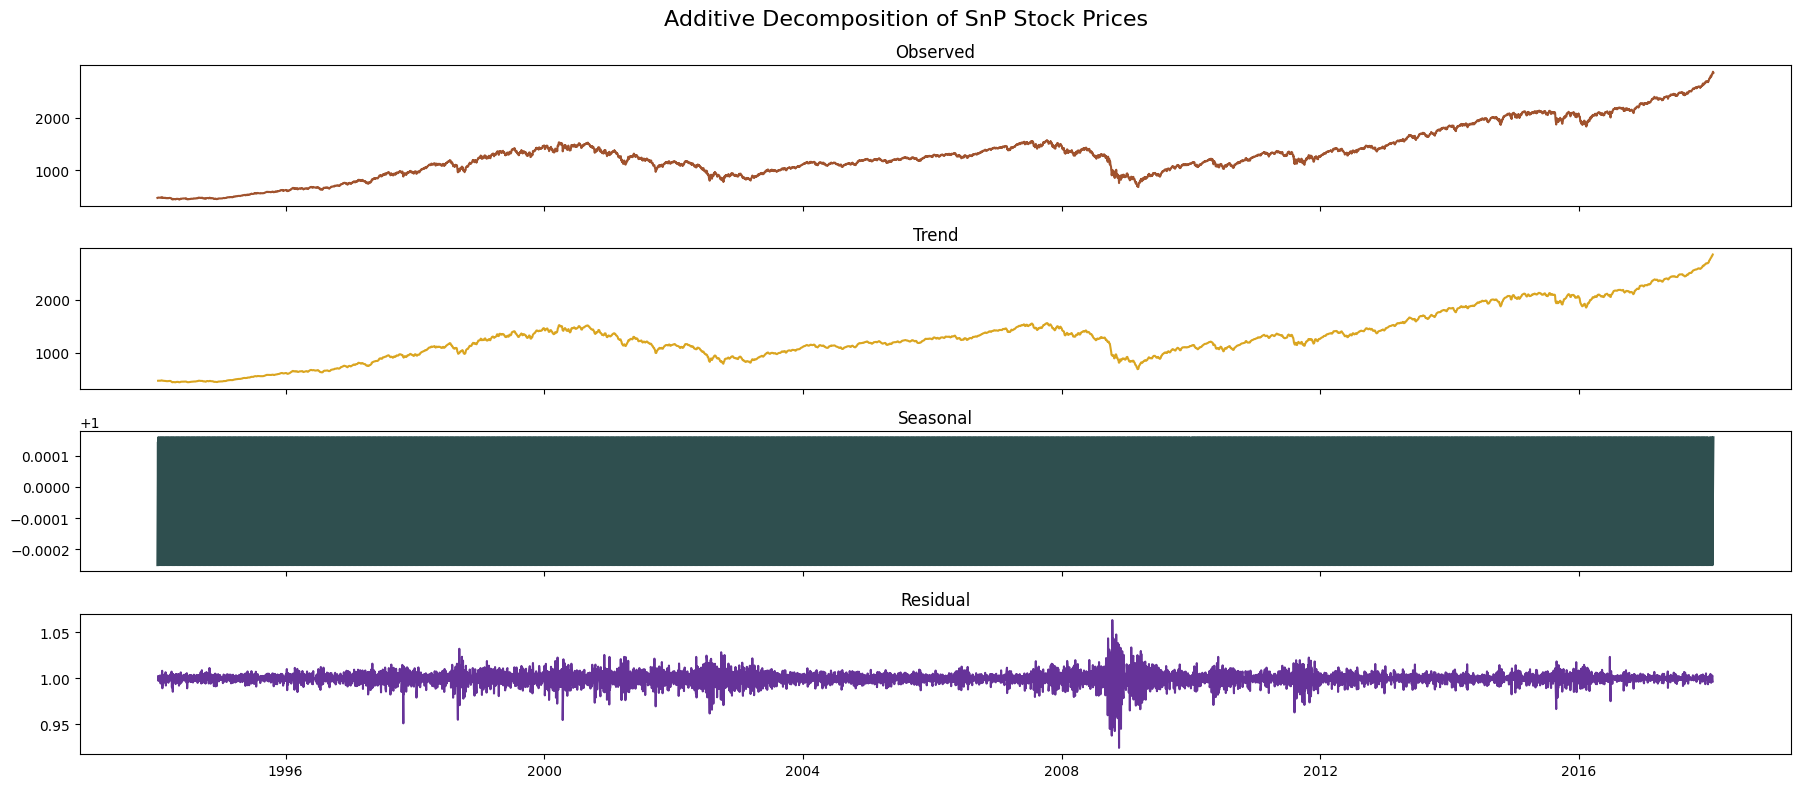

In [ ]:
result = seasonal_decompose(df['spx'], model='multiplicative', period=5)


# Plot and save classical decomp components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle(' Multiplicative Decomposition of SnP Stock Prices', fontsize=16)
plt.tight_layout()

What the above decomposition plot tells us is, there is no seasonality in our time series data. Which checks out for stock price data-stock prices are highly volatile, so it makes sense that the decomposition did not find any repearting pattern every 5 days.
I used a more advanced decomposition technique called STL- Seasonal and Trend decomposition using Loess, just to be sure (and to give you another reference in case you need it), and it confirmed that indeed my time series data has no seasonality.

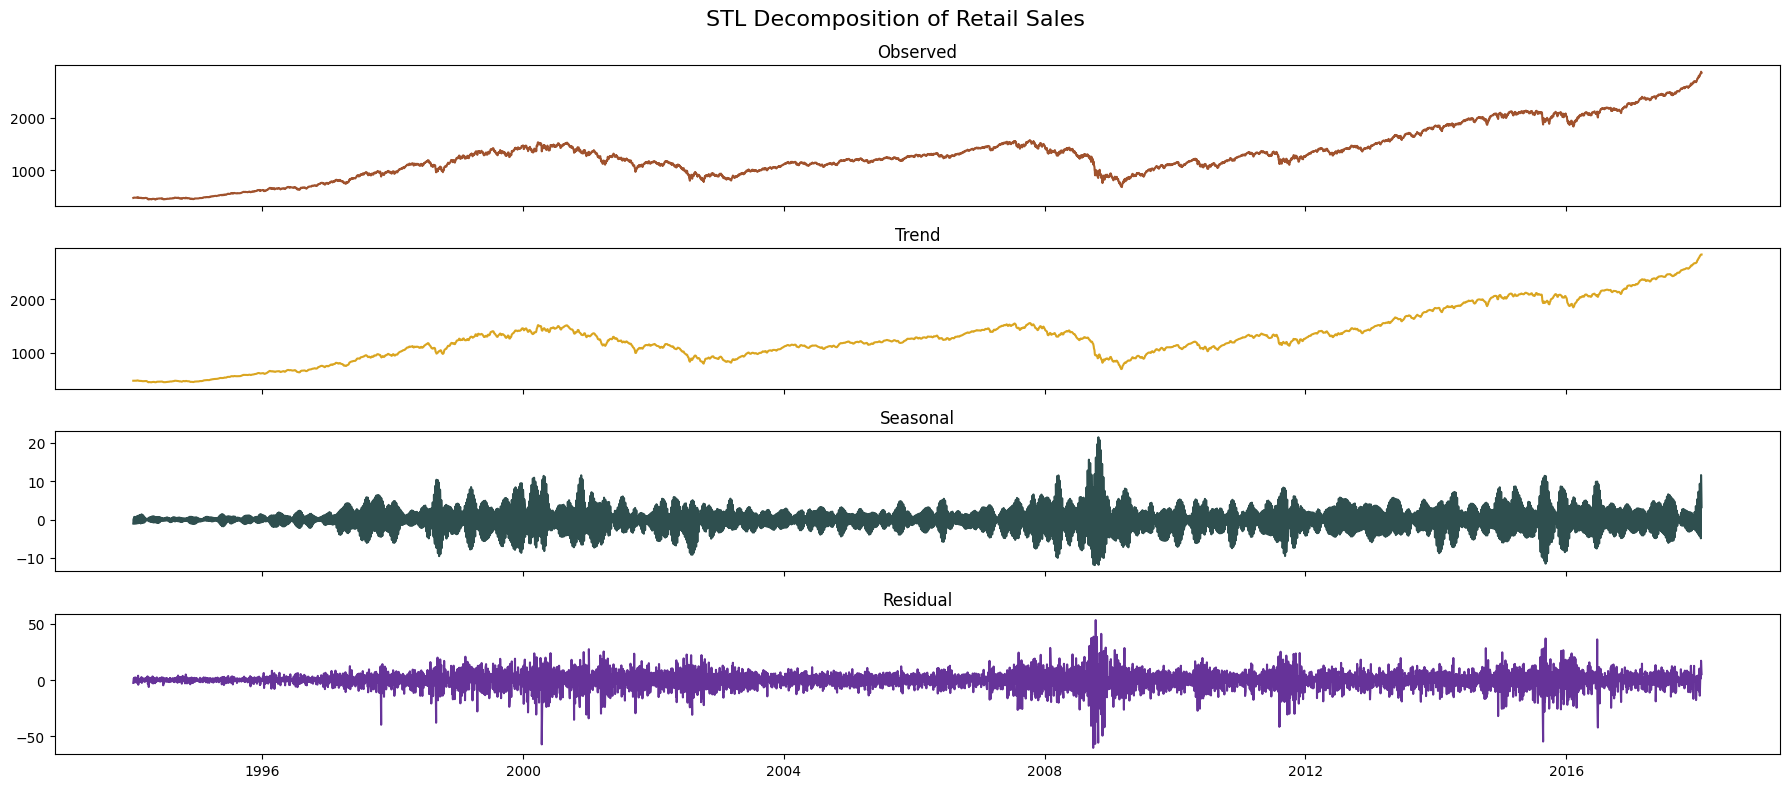

In [72]:
# Apply STL decomposition
stl = STL(df_trading['spx'], seasonal=13,period=5)
result = stl.fit()

# Plot and save STL components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle('STL Decomposition of Retail Sales', fontsize=16)
plt.tight_layout()
plt.show()

#### Insights from Time-Series Decomposition
- The time series has no seasonality and therefore, I do not need any models like SARIMA that has a seasonal component.
- The trend component explains most of the variability in our time-series data
- The time series is non-stationary as it has trend

#### Checking for Stationarity

In [74]:
result = adfuller(df_trading['spx'])

In [76]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Decision based on p-value
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0). The time series is stationary.")
else:
    print("The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.")

ADF Statistic: 1.0724042027036529
p-value: 0.9949740839827675
Critical Values:
	1%: -3.4313967180469573
	5%: -2.862002556554404
	10%: -2.5670162159104
The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.


### 3. Pre-Processing

### 4. Modelling